In [245]:
# load packages
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import shutil

## Motivation
CAMS air pollution foreacst data is provided in two different units:
1. single-level pollutants ($PM_{2.5}$, $PM_{10}$) are saved as mass concentrations (MC) in $kg\ m^{-3}$
2. multi-level pollutants ($O_3$, $NO_2$ and $SO_2$ ) are saved as mass mixing ratios (MMR) in kg of gas per kg of air

Air quality observations are mostly reported as mass concentrations, so we need to convert MMR to mass concentrations and check the results.

## Method
For the conversion, we can use equation from https://forum.ecmwf.int/t/convert-mass-mixing-ratio-mmr-to-mass-concentration-or-to-volume-mixing-ratio-vmr/1253 :

$$
MC = MMR \times \frac{p}{RT}
$$

or

$$
MC = MMR \times \rho
$$

where $p (Pa)$, $T (K)$ and $\rho (kg/m^3)$ are ambient pressure, temperature and density, and $R$ is the specific gas constant (for dry air 287.058 $\frac{J}{kgK}$).

Air density is not directly available from the CAMS forecast, but we can get the pressure (p) and temperature (T) to calculate the density of the lowest model level.
Temperature is available on model levels, pressure can be calculated from the surface pressure following [these instruction](https://confluence.ecmwf.int/display/CKB/ERA5%3A+compute+pressure+and+geopotential+on+model+levels%2C+geopotential+height+and+geometric+height):

The model half-level pressure ($p\_half$), illustrated in Figure 2, is given by:

$$
p\_half = a + b \times sp
$$

where $sp \left( sp = e^{lnsp} \right)$ is the surface pressure (and $lnsp$ is its natural logarithm).

The pressure on model levels ($p\_ml$) is given by the mean of the pressures on the model half levels immediately above and below:

$$
p\_ml = \frac{p\_half\_above + p\_half\_below}{2}
$$

We can therefore calculate the pressure on model level 137 as the mean value between the half levels 137 and 136 using this table for the coefficients a and b:

<div style="text-align: center;">
  <img src="assets/L137_model_levels.png" alt="image" width="800"/>
</div>

Multiplying the MMR with the calculated density should give us mass concentrations in $kg\ m^{-3}$ and we can compare the results of this unit conversion with the those reported at https://myftp.ecmwf.int/files/public/cams/products/cams_global_forecast/surface_concentrations/ as a sanity check.

## Results

### implement unit conversion

In [246]:
def convert_mmr_to_mass_concentration(
    ds_cams: xr.Dataset, level=137, name="mass_concentration"
):
    if level == 137:
        p_half_above = 0 + 0.997630 * ds_cams["sp"]
        p_half_below = 0 + 1.0 * ds_cams["sp"]

    p_ml = (p_half_above + p_half_below) / 2
    T_v = ds_cams["t"] * (1 + 0.61 * ds_cams["q"])
    # surface density: rho = p_ml / (R * T)
    rho = p_ml / (287.058 * ds_cams["t"])
    # rho = p_ml / (287.058 * T_v)

    # Create a new dictionary to hold the new variables
    new_variables = {}

    for variable in ds_cams.variables:
        if ds_cams[variable].attrs.get("units") == "kg kg**-1":
            new_var_name = f"{variable}_{name}_level_{level}"
            new_variables[new_var_name] = ds_cams[variable] * rho
            new_variables[new_var_name].attrs["units"] = "kg m**-3"

    new_var_name = "air_density"
    new_variables[new_var_name] = rho
    new_variables[new_var_name].attrs["units"] = "kg m**-3"

    # Add the new variables to the datasets
    ds_cams = ds_cams.assign(new_variables)

    return ds_cams

### load test data

In [247]:
# load provided city-level data
df_cities = pd.read_csv("data/CAMS_locations_v1.csv")
df_city_reference = pd.read_csv("data/CAMS_surface_concentration_2024053012_V1.csv")
# keep only the first 8 forecasts steps (i.e. 1 day) for each city
df_city_reference = df_city_reference.groupby('location_id').head(8).reset_index(drop=True)
print("reference data:")
print(df_city_reference)

# load 1 day of CAMS foreacst data (8 time steps)
ds_single_level = xr.open_dataset("data/single_level_2024-05-30_12.+24.grib", engine="cfgrib")
ds_multi_level = xr.open_dataset("data/multi_level_2024-05-30_12.+24.grib", engine="cfgrib")
ds_cams = xr.merge([ds_single_level, ds_multi_level])

# convert longitude to [-180, 180]
ds_cams = ds_cams.assign_coords(longitude=(((ds_cams.longitude + 180) % 360) - 180))
ds_cams = ds_cams.sortby("longitude")

# convert mass mixing ratio to mass concentration
ds_cams = convert_mmr_to_mass_concentration(ds_cams, level=137, name="mass_concentration")

# convert from kg/m3 to ug/m3
ds_cams = ds_cams * 1e9
ds_cams["air_density"] = ds_cams["air_density"] / 1e9




reference data:
     location_id        valid_time       O3     NO2    PM10   PM2.5
0          AE001  2024-05-30T12:00  186.880  16.093  57.440  31.243
1          AE001  2024-05-30T15:00  102.814  32.231  51.192  28.305
2          AE001  2024-05-30T18:00   67.783  31.781  55.280  31.313
3          AE001  2024-05-30T21:00   28.505  59.562  72.433  42.178
4          AE001  2024-05-31T00:00   13.611  59.914  85.314  50.740
...          ...               ...      ...     ...     ...     ...
1219       ZW001  2024-05-30T21:00   33.761   4.699  17.254  11.945
1220       ZW001  2024-05-31T00:00   32.411   4.324  16.331  11.265
1221       ZW001  2024-05-31T03:00   30.714   4.750  18.359  12.675
1222       ZW001  2024-05-31T06:00   38.424   3.470  22.447  15.543
1223       ZW001  2024-05-31T09:00   54.445   0.384   8.112   5.560

[1224 rows x 6 columns]


### extract city-level data from forecast

In [248]:
def transform_parallel(ds_cams, df_cities):
    latitudes = df_cities["latitude"].values
    longitudes = df_cities["longitude"].values
    
    # Interpolate dataset to city locations
    ds_cams_int = ds_cams.interp(
        latitude = xr.DataArray(latitudes, dims="city"),
        longitude = xr.DataArray(longitudes, dims="city"),
        method = "linear",
    )

    ds_cams_int['city'] = df_cities["id"].values

    return ds_cams_int

# output dimensions: (step: 8, city: 153)
ds_cams_city = transform_parallel(ds_cams, df_cities)

print(ds_cams_city.valid_time)


<xarray.DataArray 'valid_time' (step: 8)> Size: 64B
array(['2024-05-30T12:00:00.000000000', '2024-05-30T15:00:00.000000000',
       '2024-05-30T18:00:00.000000000', '2024-05-30T21:00:00.000000000',
       '2024-05-31T00:00:00.000000000', '2024-05-31T03:00:00.000000000',
       '2024-05-31T06:00:00.000000000', '2024-05-31T09:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    number      int64 8B 0
    time        datetime64[ns] 8B 2024-05-30T12:00:00
  * step        (step) timedelta64[ns] 64B 00:00:00 03:00:00 ... 21:00:00
    surface     float64 8B 0.0
    valid_time  (step) datetime64[ns] 64B 2024-05-30T12:00:00 ... 2024-05-31T...
    hybrid      float64 8B 137.0
Attributes:
    standard_name:  time
    long_name:      time


### merge interpolated and reference data

In [249]:
# Convert the xarray dataset to a DataFrame for easier manipulation
df_cams_interp = ds_cams_city.to_dataframe().reset_index().round(3)

# Ensure valid_time is in the same format in both datasets
df_cams_interp['valid_time'] = df_cams_interp['valid_time'].dt.strftime('%Y-%m-%dT%H:%M:%S')
df_city_reference['valid_time'] = pd.to_datetime(df_city_reference['valid_time']).dt.strftime('%Y-%m-%dT%H:%M:%S')

# rename columns to match
df_cams_interp = df_cams_interp.rename(columns={
    'go3_mass_concentration_level_137': 'O3',
    'no2_mass_concentration_level_137': 'NO2',
    'pm10': 'PM10',
    'pm2p5': 'PM2.5'
})
# Merge the xarray DataFrame with the reference DataFrame
merged_df = pd.merge(df_cams_interp, df_city_reference, left_on=['city', 'valid_time'], right_on=['location_id', 'valid_time'], suffixes=('_interp', '_ref'))

merged_df

,step,city,number,time,surface,valid_time,hybrid,PM2.5_interp,sp,PM10_interp,...,q_mass_concentration_level_137,NO2_interp,air_density,latitude,longitude,location_id,O3_ref,NO2_ref,PM10_ref,PM2.5_ref
0,0 days 00:00:00,AE001,0,2024-05-30 12:00:00,0.0,2024-05-30T12:00:00,137.0,31.243,9.974786e+13,57.440,...,2.008146e+07,16.133,1.120,25.066,55.171,AE001,186.880,16.093,57.440,31.243
1,0 days 00:00:00,AE002,0,2024-05-30 12:00:00,0.0,2024-05-30T12:00:00,137.0,22.318,1.000242e+14,44.578,...,1.870155e+07,9.015,1.123,24.467,54.367,AE002,115.098,9.019,44.578,22.318
2,0 days 00:00:00,AF001,0,2024-05-30 12:00:00,0.0,2024-05-30T12:00:00,137.0,4.734,7.874999e+13,25.324,...,3.954992e+06,0.900,0.925,34.528,69.172,AF001,95.930,0.899,25.324,4.734
3,0 days 00:00:00,AR001,0,2024-05-30 12:00:00,0.0,2024-05-30T12:00:00,137.0,14.727,1.022946e+14,21.155,...,9.412137e+06,23.593,1.249,-34.613,-58.377,AR001,9.758,23.588,21.155,14.727
4,0 days 00:00:00,AR002,0,2024-05-30 12:00:00,0.0,2024-05-30T12:00:00,137.0,0.013,1.006058e+14,0.019,...,4.723382e+06,0.399,1.272,-51.623,-69.218,AR002,45.667,0.399,0.019,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,0 days 21:00:00,VN001,0,2024-05-30 12:00:00,0.0,2024-05-31T09:00:00,137.0,21.659,1.004221e+14,31.851,...,2.386492e+07,11.408,1.157,10.823,106.630,VN001,97.835,11.407,31.851,21.659
1220,0 days 21:00:00,VN002,0,2024-05-30 12:00:00,0.0,2024-05-31T09:00:00,137.0,19.875,1.000656e+14,28.300,...,1.892832e+07,7.585,1.155,21.024,105.841,VN002,136.718,7.585,28.300,19.875
1221,0 days 21:00:00,ZA001,0,2024-05-30 12:00:00,0.0,2024-05-31T09:00:00,137.0,13.895,8.500652e+13,20.067,...,5.174562e+06,8.305,1.015,-26.202,28.044,ZA001,83.461,8.299,20.067,13.895
1222,0 days 21:00:00,ZA002,0,2024-05-30 12:00:00,0.0,2024-05-31T09:00:00,137.0,19.849,1.015823e+14,30.831,...,9.303945e+06,14.761,1.238,-33.926,18.423,ZA002,93.304,14.766,30.831,19.849


### plot the comparison

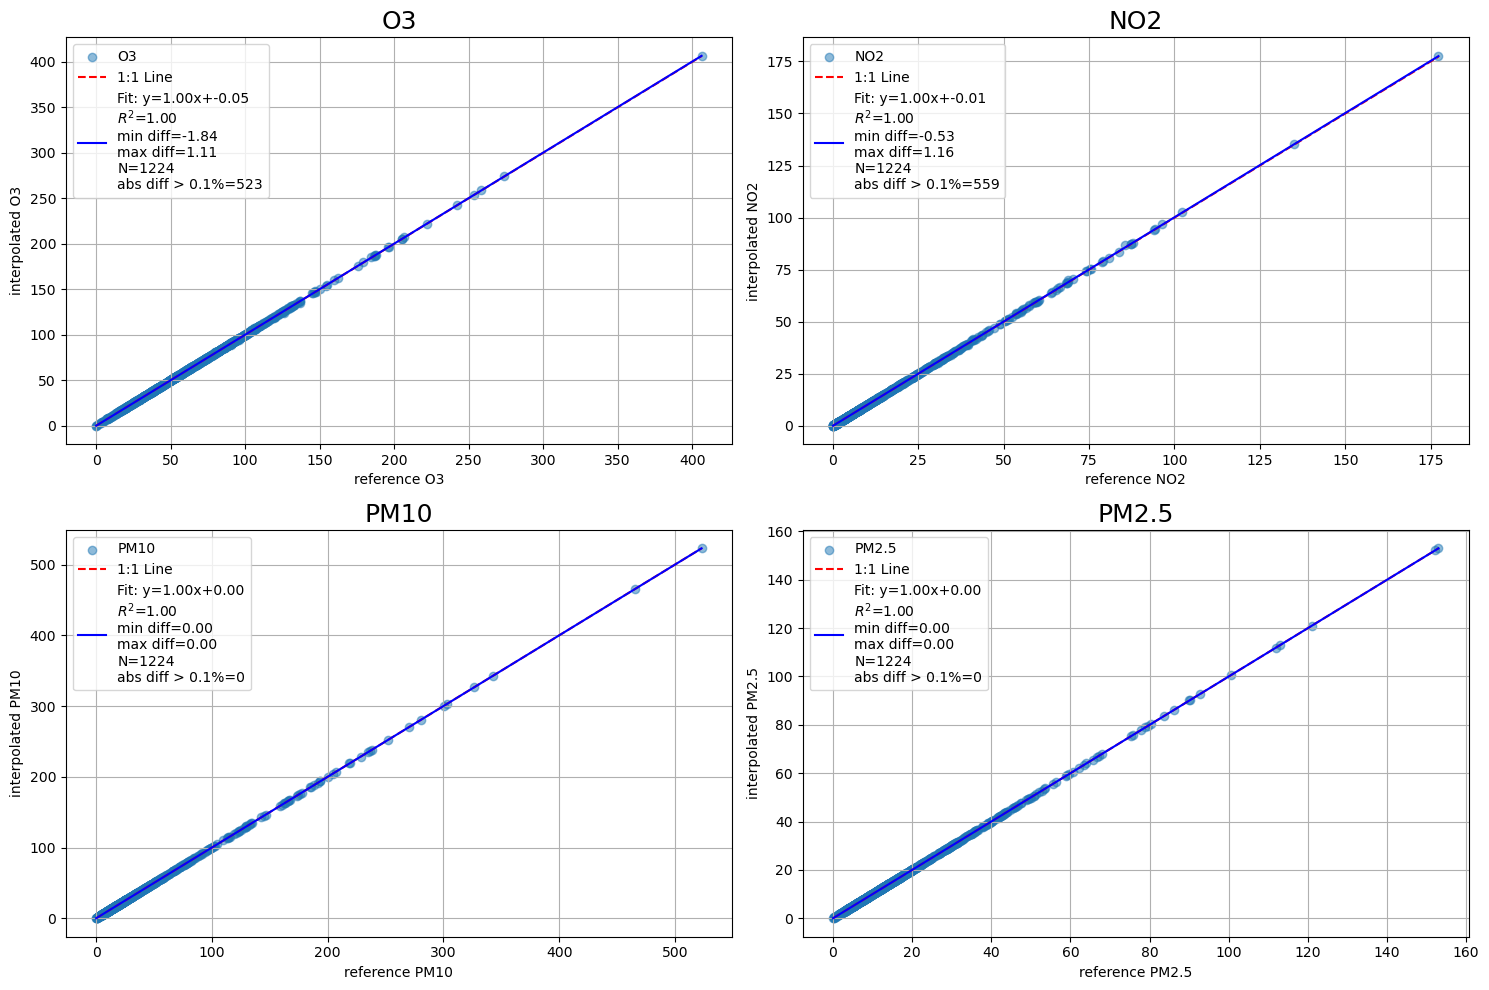

In [250]:
# # plot directories
plot_directory = "figures/02"
# if os.path.exists(plot_directory):
#     shutil.rmtree(plot_directory)
# os.makedirs(plot_directory)

from scipy.stats import linregress

# Define the variables to compare
variables = ['O3', 'NO2', 'PM10', 'PM2.5']

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for i, var in enumerate(variables):
    interp_col = f'{var}_interp'
    ref_col = f'{var}_ref'
    
    slope, intercept, r_value, p_value, std_err = linregress(merged_df[ref_col], merged_df[interp_col])
    
    # Calculate deviations from the 1:1 line
    deviations = merged_df[interp_col] - merged_df[ref_col]
    abs_deviations = deviations.abs()
    min_deviation = deviations.min()
    max_deviation = deviations.max()
    num_measurements = len(merged_df)

    # Count the number of samples with absolute deviation larger than 0.1% of the reference value
    threshold = 0.001 * merged_df[ref_col].abs()
    large_deviation_count = (abs_deviations > threshold).sum()

    ax = axs[i]
    ax.scatter(merged_df[ref_col], merged_df[interp_col], alpha=0.5, label=f'{var}')
    ax.plot([merged_df[ref_col].min(), merged_df[ref_col].max()],
            [merged_df[ref_col].min(), merged_df[ref_col].max()], 'r--', label='1:1 Line')
    
    # Add regression line
    line_x = [merged_df[ref_col].min(), merged_df[ref_col].max()]
    line_y = [slope * x + intercept for x in line_x]
    ax.plot(line_x, line_y, 'b-', label=f'Fit: y={slope:.2f}x+{intercept:.2f}\n$R^2$={r_value**2:.2f}\nmin diff={min_deviation:.2f}\nmax diff={max_deviation:.2f}\nN={num_measurements}\nabs diff > 0.1%={large_deviation_count}')    
    ax.set_xlabel(f'reference {var}')
    ax.set_ylabel(f'interpolated {var}')
    ax.set_title(f'{var}', fontsize=18)
    ax.grid(True)
    ax.legend()

# Adjust layout
plt.tight_layout()
filename = f"{plot_directory}/CAMS_interpolated_vs_reference_city_data_scatter.pdf"
plt.savefig(filename)
plt.show()
plt.close()

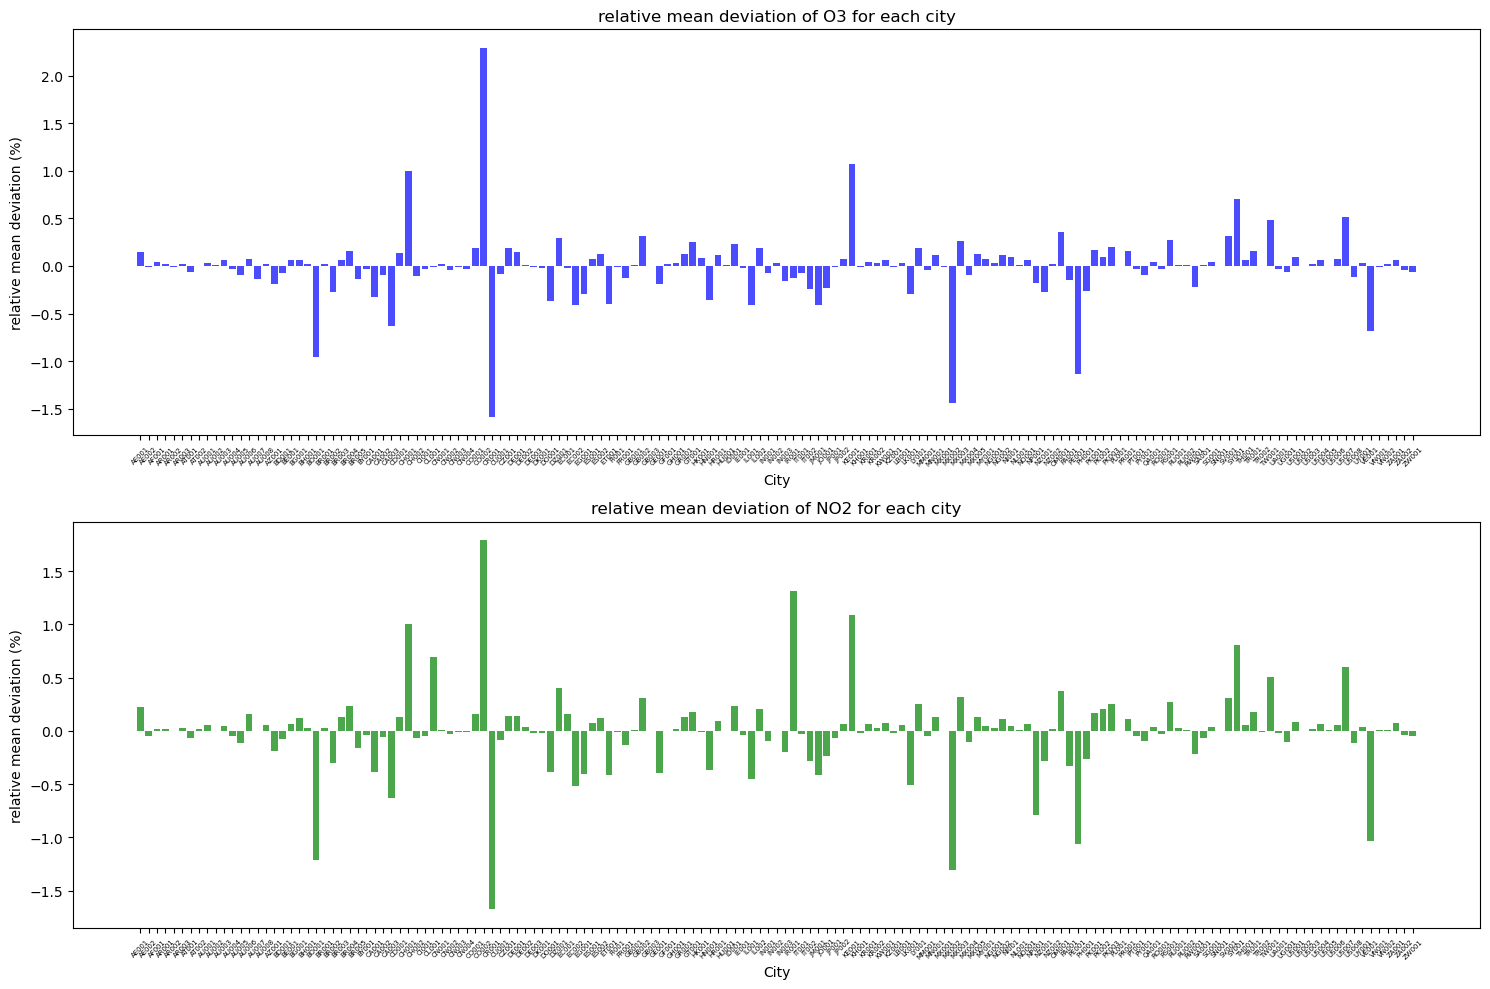

In [251]:
import matplotlib.pyplot as plt

# Calculate the relative mean deviation for each city for O3 and NO2
mean_ref_O3 = merged_df.groupby('city')['O3_ref'].mean()
mean_ref_NO2 = merged_df.groupby('city')['NO2_ref'].mean()
relative_deviation_O3 = (merged_df.groupby('city')['O3_interp'].mean() - mean_ref_O3) / mean_ref_O3 * 100
relative_deviation_NO2 = (merged_df.groupby('city')['NO2_interp'].mean() - mean_ref_NO2) / mean_ref_NO2 * 100

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot the relative mean deviation for O3
axs[0].bar(relative_deviation_O3.index, relative_deviation_O3, color='blue', alpha=0.7)
axs[0].set_xlabel('City')
axs[0].set_ylabel('relative mean deviation (%)')
axs[0].set_title('relative mean deviation of O3 for each city')
axs[0].tick_params(axis='x', rotation=45, labelsize=5)

# Plot the relative mean deviation for NO2
axs[1].bar(relative_deviation_NO2.index, relative_deviation_NO2, color='green', alpha=0.7)
axs[1].set_xlabel('City')
axs[1].set_ylabel('relative mean deviation (%)')
axs[1].set_title('relative mean deviation of NO2 for each city')
axs[1].tick_params(axis='x', rotation=45, labelsize=5)

# Adjust layout
plt.tight_layout()
filename = f"{plot_directory}/CAMS_interpolated_vs_reference_city_bar_charts.pdf"
plt.savefig(filename)
plt.show()
plt.close()

/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_64832/2613593659.py:20: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf['geometry'] = [Point(xy) for xy in zip(gdf['longitude'], gdf['latitude'])]
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_64832/2613593659.py:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


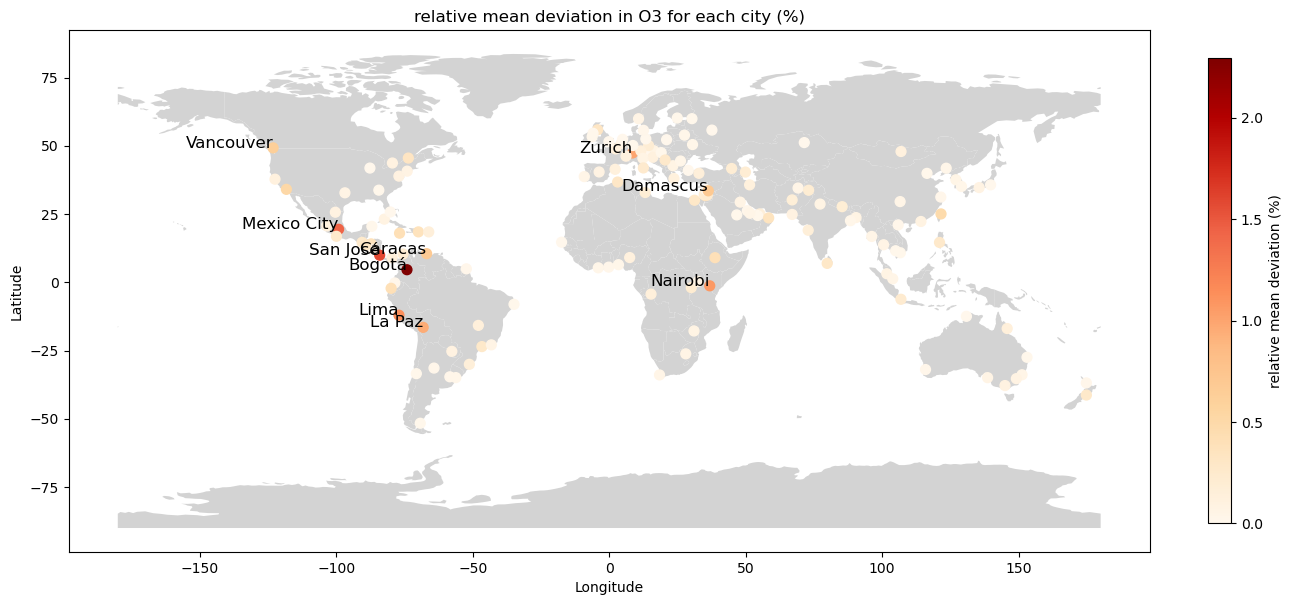

In [252]:
import geopandas as gpd
from shapely.geometry import Point

# Calculate the relative mean deviation for each city for O3 and NO2
mean_ref_O3 = merged_df.groupby('city')['O3_ref'].mean()
mean_ref_NO2 = merged_df.groupby('city')['NO2_ref'].mean()
relative_deviation_O3 = ((merged_df.groupby('city')['O3_interp'].mean() - mean_ref_O3) / mean_ref_O3).abs() * 100
relative_deviation_NO2 = ((merged_df.groupby('city')['NO2_interp'].mean() - mean_ref_NO2) / mean_ref_NO2).abs() * 100

# Combine the relative mean deviations
# relative_mean_deviation = (relative_deviation_O3 + relative_deviation_NO2) / 2
relative_mean_deviation = relative_deviation_O3

# Retrieve city names and coordinates from df_cities
city_info = df_cities.set_index('id')[['city', 'latitude', 'longitude']]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(city_info)
gdf['relative_mean_deviation'] = relative_mean_deviation
gdf['geometry'] = [Point(xy) for xy in zip(gdf['longitude'], gdf['latitude'])]

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey')

gdf.plot(column='relative_mean_deviation', ax=ax, legend=True, cmap='OrRd', markersize=50,
         legend_kwds={'label': "relative mean deviation (%)", 'fraction': 0.02})
ax.set_title('relative mean deviation in O3 for each city (%)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add labels for the top three cities
top_three_cities = relative_mean_deviation.nlargest(10).index
for city in top_three_cities:
    city_row = gdf.loc[city]
    ax.text(city_row['longitude'], city_row['latitude'], city_row['city'], fontsize=12, ha='right')

plt.tight_layout
filename = f"{plot_directory}/CAMS_interpolated_vs_reference_global_map.pdf"
plt.savefig(filename)
plt.show()
plt.close()


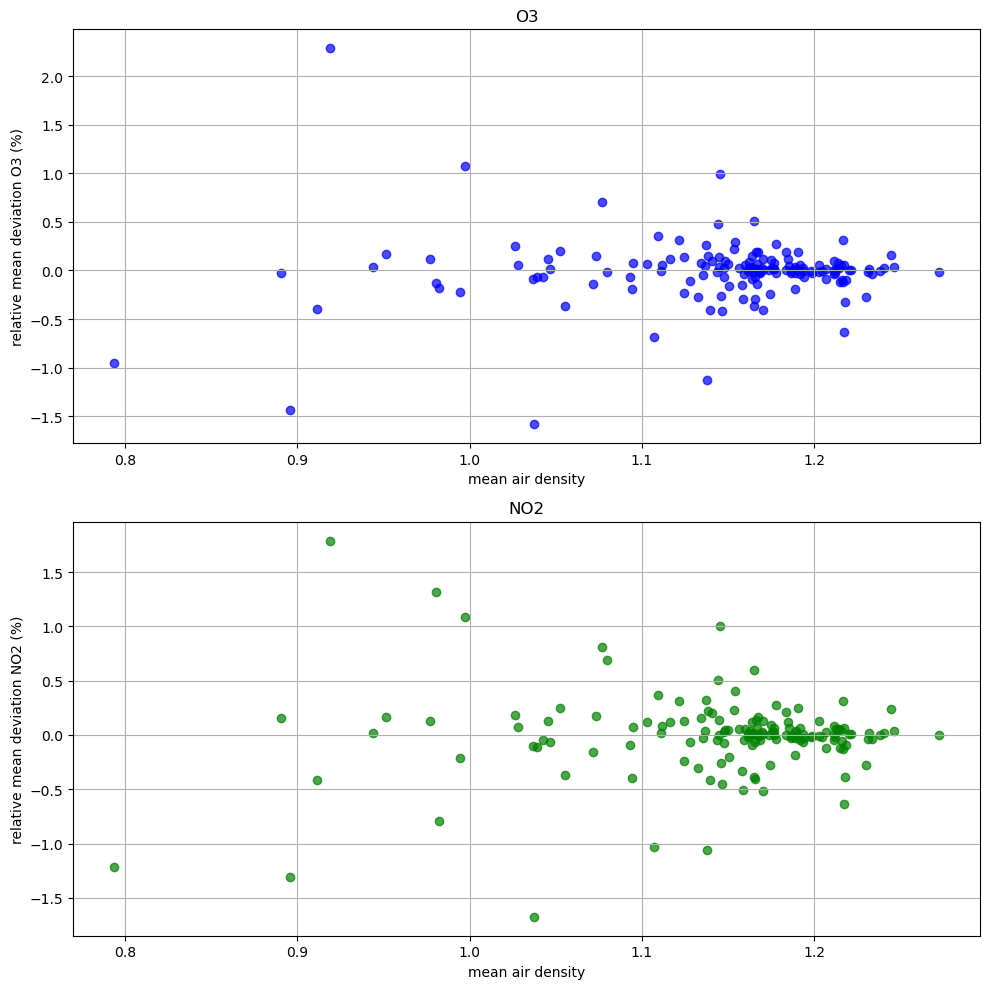

In [253]:

# Calculate the relative mean deviation for each city for O3 and NO2
mean_ref_O3 = merged_df.groupby('city')['O3_ref'].mean()
mean_ref_NO2 = merged_df.groupby('city')['NO2_ref'].mean()
relative_deviation_O3 = (merged_df.groupby('city')['O3_interp'].mean() - mean_ref_O3) / mean_ref_O3 * 100
relative_deviation_NO2 = (merged_df.groupby('city')['NO2_interp'].mean() - mean_ref_NO2) / mean_ref_NO2 * 100

# Calculate the mean air density for each city
mean_air_density = merged_df.groupby('city')['air_density'].mean()

# Combine the relative mean deviations with mean air density into a DataFrame
deviation_data = pd.DataFrame({
    'relative_deviation_O3': relative_deviation_O3,
    'relative_deviation_NO2': relative_deviation_NO2,
    'mean_air_density': mean_air_density
}).dropna()

# Create scatter plots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Scatter plot for O3
axs[0].scatter(deviation_data['mean_air_density'], deviation_data['relative_deviation_O3'], color='blue', alpha=0.7)
axs[0].set_xlabel('mean air density')
axs[0].set_ylabel('relative mean deviation O3 (%)')
axs[0].set_title('O3')
axs[0].grid(True)

# Scatter plot for NO2
axs[1].scatter(deviation_data['mean_air_density'], deviation_data['relative_deviation_NO2'], color='green', alpha=0.7)
axs[1].set_xlabel('mean air density')
axs[1].set_ylabel('relative mean deviation NO2 (%)')
axs[1].set_title('NO2')
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
filename = f"{plot_directory}/CAMS_interpolated_vs_reference_mean_deviation_air_density_scatter_plots.pdf"
plt.savefig(filename)
plt.show()
plt.close()

/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_64832/3073643011.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_cities_data['valid_time'] = pd.to_datetime(top_cities_data['valid_time'])


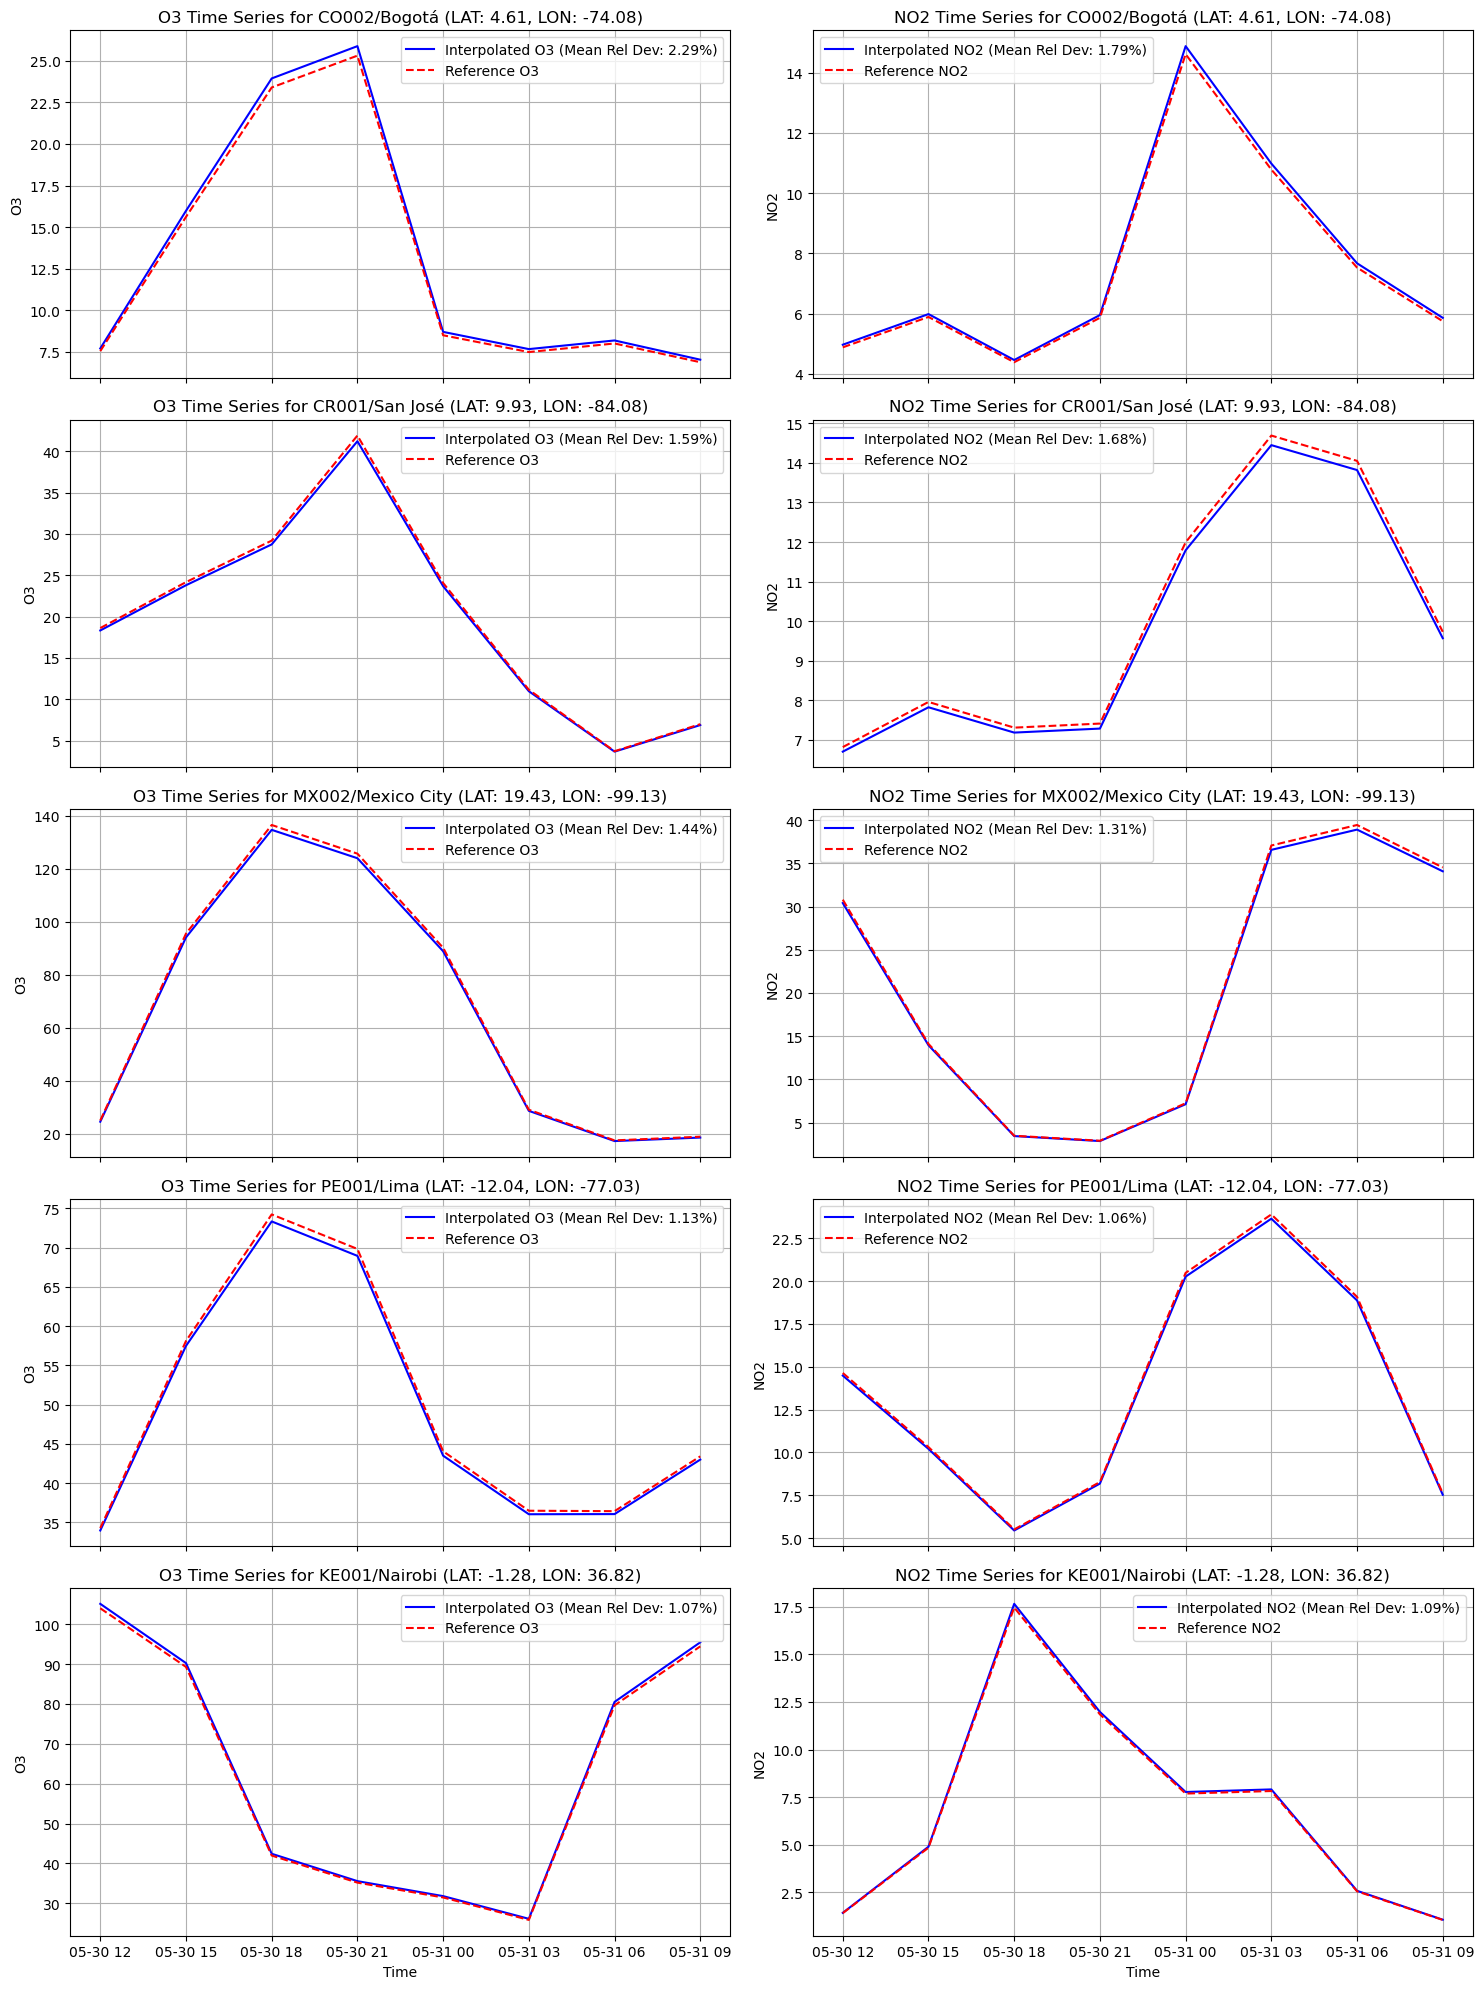

In [254]:

# Calculate the relative mean deviation for each city for O3 and NO2
mean_ref_O3 = merged_df.groupby('city')['O3_ref'].mean()
mean_ref_NO2 = merged_df.groupby('city')['NO2_ref'].mean()
relative_deviation_O3 = ((merged_df.groupby('city')['O3_interp'].mean() - mean_ref_O3) / mean_ref_O3).abs() * 100
relative_deviation_NO2 = ((merged_df.groupby('city')['NO2_interp'].mean() - mean_ref_NO2) / mean_ref_NO2).abs() * 100

# Combine the relative mean deviations and find the top three cities with the highest relative mean deviation
# relative_mean_deviation = (relative_deviation_O3 + relative_deviation_NO2) / 2
relative_mean_deviation = relative_deviation_O3
top_cities = relative_mean_deviation.nlargest(5).index

# Extract the time series data for the top three cities
top_cities_data = merged_df[merged_df['city'].isin(top_cities)]

# Convert 'valid_time' to datetime for plotting
top_cities_data['valid_time'] = pd.to_datetime(top_cities_data['valid_time'])

# Retrieve city names and coordinates from df_cities
city_info = df_cities.set_index('id')[['city', 'latitude', 'longitude']]

# Plot the time series for O3 and NO2 for the top three cities
fig, axs = plt.subplots(5, 2, figsize=(15, 20), sharex=True)

for i, city in enumerate(top_cities):
    city_data = top_cities_data[top_cities_data['city'] == city]
    
    city_name = city_info.loc[city, 'city']
    city_lat = city_info.loc[city, 'latitude']
    city_lon = city_info.loc[city, 'longitude']
    rel_mean_dev_O3 = relative_deviation_O3.loc[city]
    rel_mean_dev_NO2 = relative_deviation_NO2.loc[city]
    
    axs[i, 0].plot(city_data['valid_time'], city_data['O3_interp'], label=f'Interpolated O3 (Mean Rel Dev: {rel_mean_dev_O3:.2f}%)', color='blue')
    axs[i, 0].plot(city_data['valid_time'], city_data['O3_ref'], label='Reference O3', color='red', linestyle='dashed')
    axs[i, 0].set_title(f'O3 Time Series for {city}/{city_name} (LAT: {city_lat:.2f}, LON: {city_lon:.2f})')
    axs[i, 0].set_ylabel('O3')
    axs[i, 0].legend()
    axs[i, 0].grid(True)
    
    axs[i, 1].plot(city_data['valid_time'], city_data['NO2_interp'], label=f'Interpolated NO2 (Mean Rel Dev: {rel_mean_dev_NO2:.2f}%)', color='blue')
    axs[i, 1].plot(city_data['valid_time'], city_data['NO2_ref'], label='Reference NO2', color='red', linestyle='dashed')
    axs[i, 1].set_title(f'NO2 Time Series for {city}/{city_name} (LAT: {city_lat:.2f}, LON: {city_lon:.2f})')
    axs[i, 1].set_ylabel('NO2')
    axs[i, 1].legend()
    axs[i, 1].grid(True)

axs[-1, 0].set_xlabel('Time')
axs[-1, 1].set_xlabel('Time')

plt.tight_layout()
filename = f"{plot_directory}/CAMS_interpolated_vs_reference_top_time_series.pdf"
plt.savefig(filename)
plt.show()
plt.close()
